 MySQL 연결 성공


C:\Users\campus4D051\AppData\Local\Temp\ipykernel_14272\1103954590.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn, params=params)


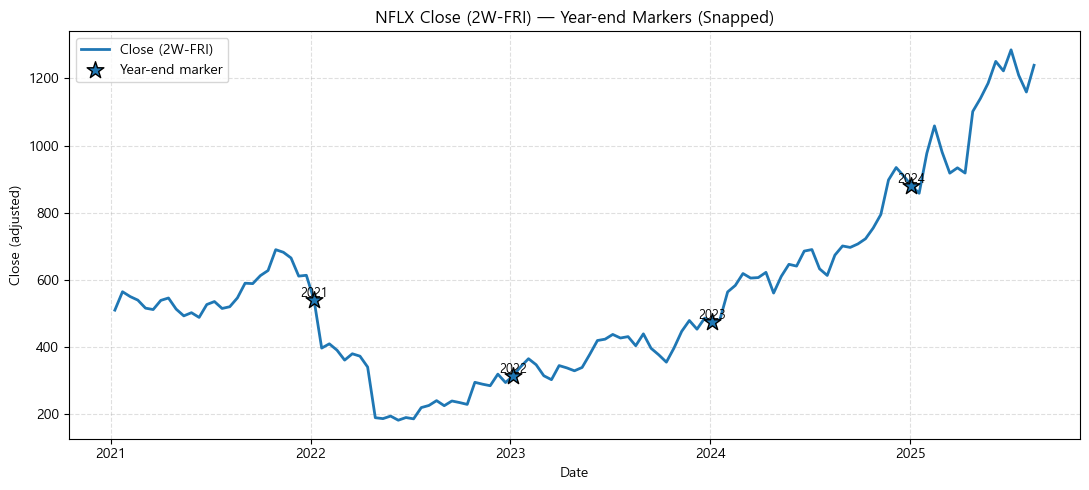


5년간 총 상승률 : 136.956%
5년간 연평균 상승률(단순 평균) : 27.391%
5년간 연평균 상승률(CAGR, 복리 기준) : 18.832%
 Year   close_ye  prev_close_ye  yoy_pct
 2021 602.440002            NaN      NaN
 2022 294.880005     602.440002   -51.05
 2023 486.880005     294.880005    65.11
 2024 891.320007     486.880005    83.07


C:\Users\campus4D051\AppData\Local\Temp\ipykernel_14272\1103954590.py:154: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  .resample("A-DEC")        # 매년 12월 말


In [ ]:
# ============================================
# NFLX: 격주(2W-FRI) 주가 & 연말(2021~2024) 마커 + 전/후 수익률
# ============================================
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------------
# 1) MySQL 연결/조회 유틸
# ----------------------------
def connect_to_database(
    host="10.100.1.82", port=3303, user="teamuser1",
    password="1234", database="our_project_db"
):
    try:
        conn = mysql.connector.connect(
            host=host, port=port, user=user, password=password, database=database
        )
        if conn.is_connected():
            print(" MySQL 연결 성공")
            return conn
    except mysql.connector.Error as err:
        print(f" MySQL 연결 오류: {err}")
    return None

def sql_to_df(conn, query, params=None):
    return pd.read_sql(query, conn, params=params)

# ----------------------------
# 2) 최근접 스냅 유틸
# ----------------------------
def snap_to_index(dts, target_index):
    """
    dts: list-like of timestamps (or single Timestamp)
    target_index: DatetimeIndex to snap to (method='nearest')
    """
    dts = pd.to_datetime(pd.Index(dts))
    pos = target_index.get_indexer(dts, method="nearest")
    return target_index[pos]

# ----------------------------
# 3) 메인
# ----------------------------
if __name__ == "__main__":
    conn = connect_to_database()
    if conn is None:
        raise SystemExit("DB 연결 실패로 종료합니다.")

    try:
        # -- 3.1) 원본 일별 주가 로드
        q_stock = """
            SELECT DISTINCT `Date`, `Close`
            FROM our_project_db.nflx_final
            ORDER BY `Date` ASC
        """
        df_stock = sql_to_df(conn, q_stock)
        df_stock["Date"]  = pd.to_datetime(df_stock["Date"], errors="coerce")
        df_stock["Close"] = pd.to_numeric(df_stock["Close"], errors="coerce")

        df_stock = (
            df_stock
            .dropna(subset=["Date", "Close"])
            .drop_duplicates(subset=["Date"])
            .sort_values("Date")
            .reset_index(drop=True)
        )
        if df_stock.empty:
            raise SystemExit("df_stock이 비어 있습니다. 원본 테이블을 확인하세요.")

        # -- 3.2) 2주봉(금요일 앵커) 변환
        wk_2w = (
            df_stock
            .set_index("Date")
            .resample("2W-FRI")
            .last()
            .dropna(subset=["Close"])
            .copy()
        )
        if wk_2w.empty:
            raise SystemExit("2W-FRI 리샘플 결과가 비었습니다.")

        # -- 3.3) 연말 4개 타깃 날짜 지정 → 2주봉 인덱스에 최근접 스냅
        targets = [pd.Timestamp(f"{y}-12-31") for y in (2021, 2022, 2023, 2024)]
        snap_dates = snap_to_index(targets, wk_2w.index)

        # ----------------------------
        # 4) 시각화
        # ----------------------------
        try:
            plt.rcParams["font.family"] = "Malgun Gothic"  # Windows 한글 폰트
        except Exception:
            pass
        plt.rcParams["axes.unicode_minus"] = False

        fig, ax = plt.subplots(figsize=(11, 5))
        ax.plot(wk_2w.index, wk_2w["Close"], linewidth=2, label="Close (2W-FRI)")

        # 마커
        ax.scatter(
            snap_dates, wk_2w.loc[snap_dates, "Close"],
            marker="*", s=160, edgecolors="black", zorder=3, label="Year-end marker"
        )
        # 연도 라벨
        for y, sd in zip((2021, 2022, 2023, 2024), snap_dates):
            ax.text(sd, wk_2w.loc[sd, "Close"], s=str(y),
                    ha="center", va="bottom", fontsize=9)

        ax.set_title("NFLX Close (2W-FRI) — Year-end Markers (Snapped)")
        ax.set_xlabel("Date"); ax.set_ylabel("Close (adjusted)")
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend(loc="best")
        plt.tight_layout()
        plt.show()

    finally:
        try:
            conn.close()
        except Exception:
            pass

# 시작, 끝 주가
start_price = df_stock['Close'].iloc[0]
end_price   = df_stock['Close'].iloc[1102]   # 5년 후

# 기간(년수)
years = 5

# 총 상승률
total_return = (end_price / start_price - 1) * 100

# 단순 평균 상승률
avg_return = total_return / years

# CAGR (연평균 복리 성장률)
cagr = ((end_price / start_price) ** (1/years) - 1) * 100

# 출력
print(f"\n5년간 총 상승률 : {total_return:.3f}%")
print(f"5년간 연평균 상승률(단순 평균) : {avg_return:.3f}%")
print(f"5년간 연평균 상승률(CAGR, 복리 기준) : {cagr:.3f}%")


df = df_stock.copy()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date", "Close"]).sort_values("Date")

# 연말(12월 말) '마지막 관측값' = 마지막 거래일 종가
yearly_last = (
    df.set_index("Date")
      .resample("A-DEC")        # 매년 12월 말
      .last()
      .dropna(subset=["Close"])
)

# 2021~2024만 추리기(필요 시)
yearly_last = yearly_last.loc["2021":"2024"]

# 결과 테이블: 연도 / 연말종가 / 전년 연말종가 / YoY(%)
out = yearly_last[["Close"]].rename(columns={"Close":"close_ye"})
out["prev_close_ye"] = out["close_ye"].shift(1)
out["yoy_pct"] = ((out["close_ye"] / out["prev_close_ye"] - 1) * 100).round(2)
out["Year"] = out.index.year
out = out[["Year","close_ye","prev_close_ye","yoy_pct"]].reset_index(drop=True)

print(out.to_string(index=False))


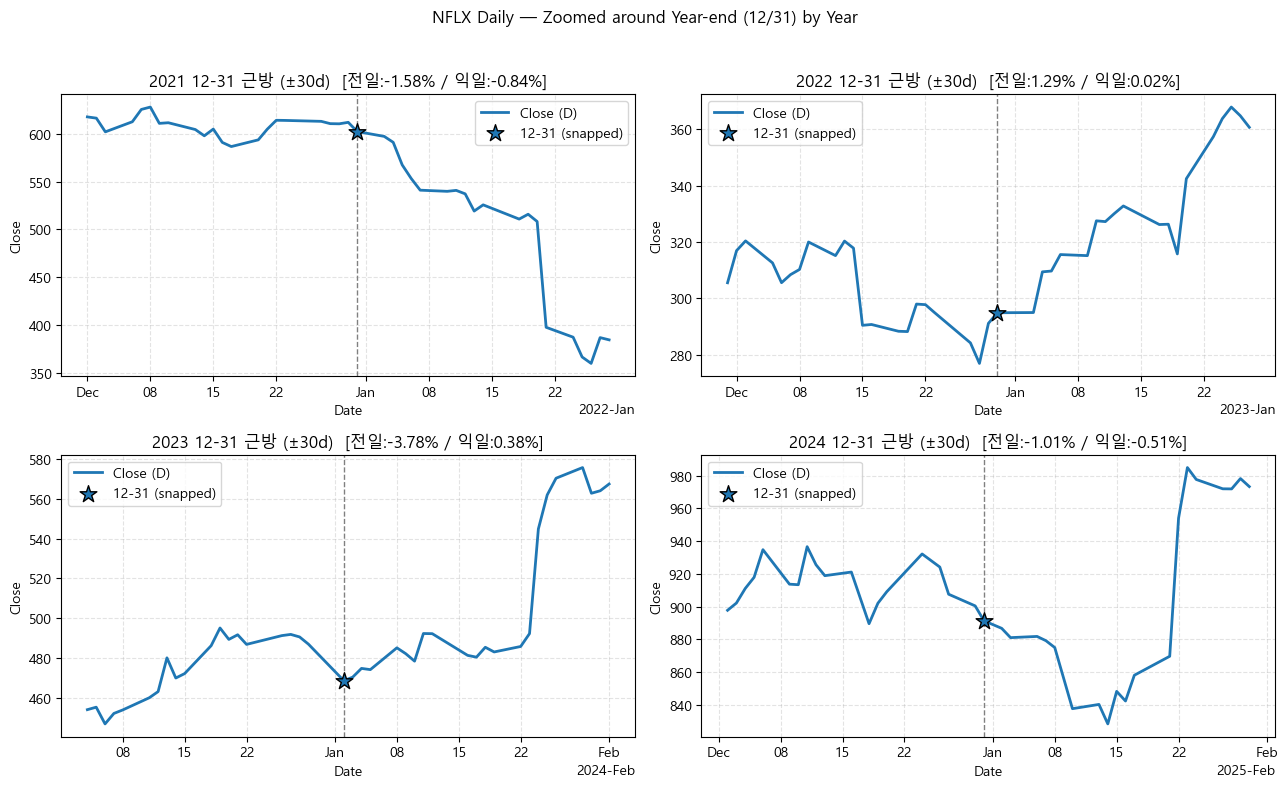

In [42]:
# ============================================
# 2x2 확대: 연말(12-31) 일봉 전후 확대 그래프 (2021~2024)
# ============================================

def nearest_trading_day(ts, idx: pd.DatetimeIndex):
    pos = idx.get_indexer([pd.to_datetime(ts)], method="nearest")[0]
    return idx[pos]

# 일봉(이미 df_stock이 일봉) 정리
daily = (
    df_stock
    .dropna(subset=["Date","Close"])
    .drop_duplicates(subset=["Date"])
    .sort_values("Date")
    .set_index("Date")
)

# 대상 연도/창 크기(캘린더 기준)
years = [2021, 2022, 2023, 2024]
window_days = 30   # 12-31 ± 30일(원하면 15~45 등으로 조절)

# 2x2 서브플롯
try:
    plt.rcParams["font.family"] = "Malgun Gothic"
except Exception:
    pass
plt.rcParams["axes.unicode_minus"] = False

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
axes = axes.flatten()

for ax, y in zip(axes, years):
    target = pd.Timestamp(f"{y}-12-31")
    if len(daily.index) == 0:
        raise SystemExit("일봉 데이터(daily)가 비어 있습니다.")

    # 12-31을 가장 가까운 거래일로 스냅
    snap = nearest_trading_day(target, daily.index)

    # 확대 구간 (캘린더 기준)
    start = snap - pd.Timedelta(days=window_days)
    end   = snap + pd.Timedelta(days=window_days)

    seg = daily.loc[start:end].copy()
    if seg.empty:
        ax.set_title(f"{y} (데이터 없음)")
        ax.axis("off")
        continue

    # 전/익일 수익률(%) 계산(가능할 때만)
    try:
        loc = daily.index.get_loc(snap)
        prev_close = daily["Close"].iloc[loc-1] if loc > 0 else np.nan
        curr_close = daily["Close"].iloc[loc]
        next_close = daily["Close"].iloc[loc+1] if loc < len(daily)-1 else np.nan

        ret_prev = (curr_close/prev_close - 1)*100 if pd.notna(prev_close) else np.nan
        ret_next = (next_close/curr_close - 1)*100 if pd.notna(next_close) else np.nan
    except Exception:
        prev_close = curr_close = next_close = ret_prev = ret_next = np.nan

    # 그래프
    ax.plot(seg.index, seg["Close"], linewidth=2, label="Close (D)")
    # 스냅 포인트
    if snap in seg.index:
        ax.scatter([snap], [seg.loc[snap, "Close"]],
                   marker="*", s=160, edgecolors="black", zorder=3, label="12-31 (snapped)")
        ax.axvline(snap, color="gray", linestyle="--", linewidth=1)

    # 제목/레이블
    ax.set_title(f"{y} 12-31 근방 (±{window_days}d)  "
                 f"[전일:{ret_prev:.2f}% / 익일:{ret_next:.2f}%]" if not np.isnan(ret_prev) else
                 f"{y} 12-31 근방 (±{window_days}d)")
    ax.set_xlabel("Date"); ax.set_ylabel("Close")
    ax.grid(True, linestyle="--", alpha=0.35)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.legend(loc="best")

plt.suptitle("NFLX Daily — Zoomed around Year-end (12/31) by Year", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
